# COMP4434 Project
##  The Lung Cancer Database Project

## 1. Import related libraries 

In [1]:
## import related libraries, for data visualization, data pre-processing
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.preprocessing import scale, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, SCORERS
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

## 2. Self implemented Functions and Classes

### 2.1 Regularized Logistic Regression using Gradient Descent Class

In [2]:
# self implemented regularized logistic regression using Gradient Descent
class RegularizedLogisticRegressionUsingGD:
    """Regularized Logistic Regression Using Gradient Descent.
    Parameters
    ----------
    eta : float
        Learning rate
    lam : float
        Lambda (for regularization)
    n_iterations : int
        No of passes over the training set
    Attributes
    ----------
    w_ : weights/ after fitting the model
    bias_ : bias / after fitting the model
    cost_ : total error of the model after each iteration
    """
    
    
    # constructor (take 3 parameters)
    def __init__(self, eta, lam, n_iterations):
        self.dim = 2
        self.w = None
        self.b = None
        self.eta = eta
        self.lam = lam
        self.n_iterations = n_iterations
    
    # for calculating the sigmoid function
    def sigmoid(self, x):
        return 1.0/(1+np.exp(-x))
    
    ## returning the theta for each features
    def theta(self):
        return self.w
    
    # model training
    def fit(self, x, y):
        itr = 0
        row, column = np.shape(x)
        ##print('number of samples:', row)
        self.w = np.zeros(column)
        self.b = 0
        while itr <= self.n_iterations:
            fx = np.dot(self.w, x.T) + self.b
            hx = self.sigmoid(fx)
            t = (hx-y)

            ##s = [[i[0]*i[1][0],i[0]*i[1][1]] for i in zip(t,x)]
            gradient_w = (1/row) * np.dot(x.T, (t))
            ##gradient_w = np.sum(s, 0)/row * self.eta
            gradient_b = (1/row) * np.sum(t)
            ##gradient_b = np.sum(t, 0)/row * self.eta
            ##self.w -= self.eta * gradient_w
            self.w = self.w * (1 - self.lam * self.eta / row) - self.eta * gradient_w
            self.b -= self.eta * gradient_b
            itr +=1
            
    # predict model, return the probabilities [0-1.0]
    def predictProb(self, x):
        fx = np.dot(self.w, x.T) + self.b
        y_pred = self.sigmoid(fx)
        return y_pred
    
    # predict model, return class label [0/1]
    def predict(self, x):
        fx = np.dot(self.w, x.T) + self.b
        y_pred = self.sigmoid(fx)
        ypts = [1 if i > 0.5 else 0 for i in y_pred]
        ## print(y_pred)
        ##ypts = (self.w[0] * x_test + self.b) / (-self.w[1])
        return ypts
    
    

### 2.2 Functions for calculate the related parameters (e.g. accuracy)

In [3]:
## self-implemented accuracy function
def accuracy(y_true, y_pred):
    accuracy = np.sum(y_true == y_pred) / len(y_true)
    return accuracy


def get_f1score(model, x_train, x_test, y_train, y_test):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    cf = confusion_matrix(y_test, y_pred)
    precision = cf[0,0] / (cf[0,0] + cf[0,1])
    recall = cf[0,0] / (cf[0,0] + cf[1,0])
    f1 = 2 * (precision * recall) / (precision + recall)
    return f1

## 3. Data pre-processing

## 3.1 Import the data

In [4]:
x_train = np.loadtxt('X_train.csv', dtype=float, delimiter=',')

print('x_train[1] = ', x_train[1])
## print('xr_train=', xs_train[1])

y_train = np.loadtxt('Y_train.csv', dtype=int, delimiter=',')

## print the shape of the imported data

print("x_train shape: ", x_train.shape)
print("y_train shape: ", y_train.shape)

## concatenate x_train with y_train in a data frame
xytrain = np.concatenate((x_train, y_train[:, None]), axis=1)
df = pd.DataFrame(xytrain,
                  columns=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 
                           11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
                           21, 22, 23, 24, 25, 26, 27, 28, 29, 30,'label'])

x_train[1] =  [1.057e+01 1.832e+01 6.682e+01 3.409e+02 8.142e-02 4.462e-02 1.993e-02
 1.111e-02 2.372e-01 5.768e-02 1.818e-01 2.542e+00 1.277e+00 1.312e+01
 1.072e-02 1.331e-02 1.993e-02 1.111e-02 1.717e-02 4.492e-03 1.094e+01
 2.331e+01 6.935e+01 3.663e+02 9.794e-02 6.542e-02 3.986e-02 2.222e-02
 2.699e-01 6.736e-02]
x_train shape:  (500, 30)
y_train shape:  (500,)


## 3.2 Feature Scaling
## 3.2.1 The need of feature scaling
### Let's print out some of the features summary (x_train)


In [5]:
df.describe()

,1,2,3,4,5,6,7,8,9,10,...,22,23,24,25,26,27,28,29,30,label
count,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,...,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,14.121168,19.181200,91.907740,653.06740,0.096484,0.104077,0.087354,0.048606,0.181321,0.062795,...,25.532840,107.086320,875.564000,0.132411,0.253360,0.268832,0.113888,0.290667,0.084059,0.376000
std,3.477383,4.273575,23.928209,342.11933,0.014096,0.052459,0.077399,0.038131,0.027682,0.007078,...,6.148854,32.741329,542.065384,0.022885,0.156420,0.200870,0.065113,0.062070,0.018289,0.484865
min,6.981000,9.710000,43.790000,143.50000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,0.000000
25%,11.655000,16.060000,74.832500,418.32500,0.086745,0.065675,0.029540,0.020497,0.162075,0.057775,...,20.875000,83.955000,513.700000,0.117075,0.145925,0.112300,0.063410,0.251225,0.071733,0.000000
50%,13.390000,18.760000,86.545000,551.40000,0.095930,0.093125,0.061545,0.033455,0.179350,0.061580,...,25.370000,97.930000,687.100000,0.131250,0.214850,0.229000,0.100015,0.283100,0.080140,0.000000
75%,15.892500,21.685000,104.800000,789.67500,0.105300,0.130325,0.127725,0.074067,0.195825,0.066090,...,29.472500,125.175000,1085.000000,0.146000,0.337600,0.381400,0.161675,0.319375,0.092105,1.000000
max,28.110000,39.280000,188.500000,2499.00000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,49.540000,220.800000,3432.000000,0.222600,1.058000,1.105000,0.291000,0.663800,0.207500,1.000000


### We can see that some features are in different scale
#### For example, feature [4] and feature [5]

In [6]:
df[4].describe()

count     500.00000
mean      653.06740
std       342.11933
min       143.50000
25%       418.32500
50%       551.40000
75%       789.67500
max      2499.00000
Name: 4, dtype: float64

In [7]:
df[5].describe()

count    500.000000
mean       0.096484
std        0.014096
min        0.052630
25%        0.086745
50%        0.095930
75%        0.105300
max        0.163400
Name: 5, dtype: float64

### Let's visualize some features with their distribution

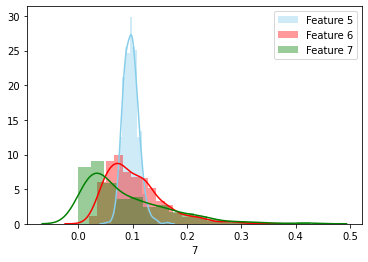

In [8]:


sns.distplot( df[5] , color="skyblue", label="Feature 5")
sns.distplot( df[6] , color="red", label="Feature 6")
sns.distplot( df[7] , color="green", label="Feature 7")
plt.legend()


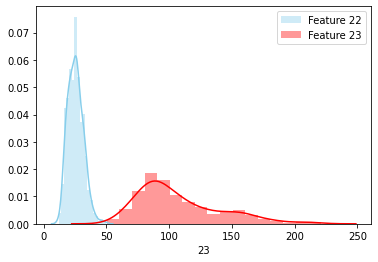

In [9]:
sns.distplot( df[22] , color="skyblue", label="Feature 22")
sns.distplot( df[23] , color="red", label="Feature 23")
plt.legend()

## 3.2.2 Perform Feature Scaling
### The above data description and graph show that the features are not in the same scale, therefore, we should perform the feature scaling

### We use the standardization formula : z = (x - u) / s
 x is original value, u is mean, s is standard deviation

before scaling: 



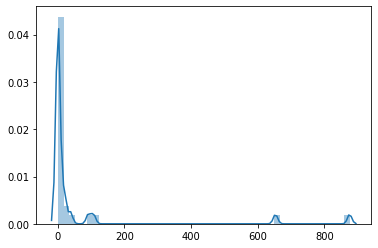

In [10]:
scale = StandardScaler()
xs_train = scale.fit_transform(x_train)


print("before scaling: \n")
sns.distplot(np.mean(x_train, axis=0))

## alternative scaling function (scale)
##xs_train = scale(x_train)

After scaling: 



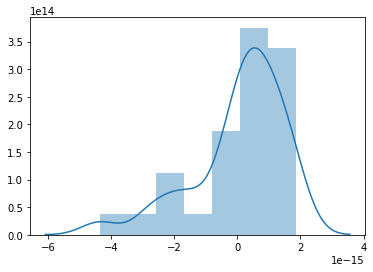

In [11]:
print("After scaling: \n")
sns.distplot(np.mean(xs_train, axis=0))

## 3.3 Feature Selection
## 3.3.1 Correlation of the features

In [12]:
xytrain = np.concatenate((xs_train, y_train[:, None]), axis=1)
print("xytrain shape = ", xytrain.shape)
df_xy = pd.DataFrame(xytrain,
                  columns=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 
                           11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
                           21, 22, 23, 24, 25, 26, 27, 28, 29, 30,'label'])

xytrain shape =  (500, 31)


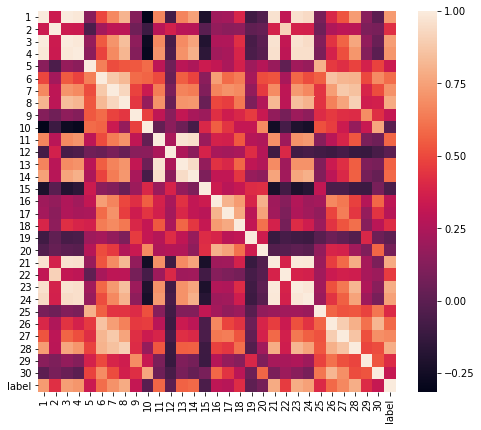

In [13]:
corr = df.corr()
fig,ax=plt.subplots(figsize=(8,7))
sns.heatmap(corr)


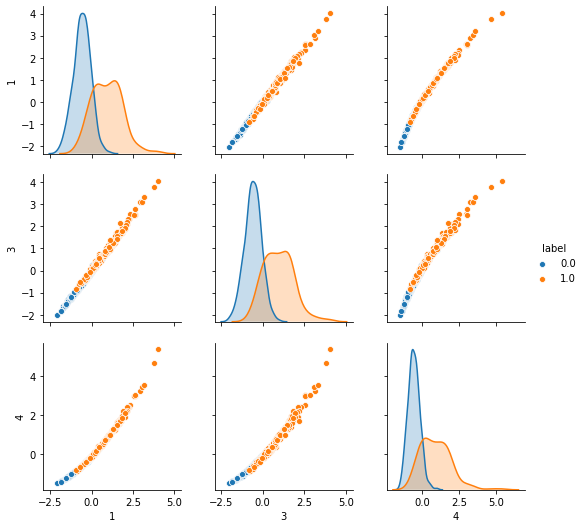

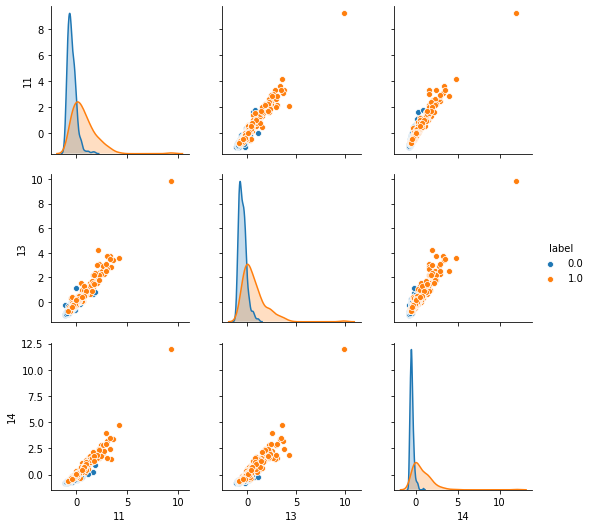

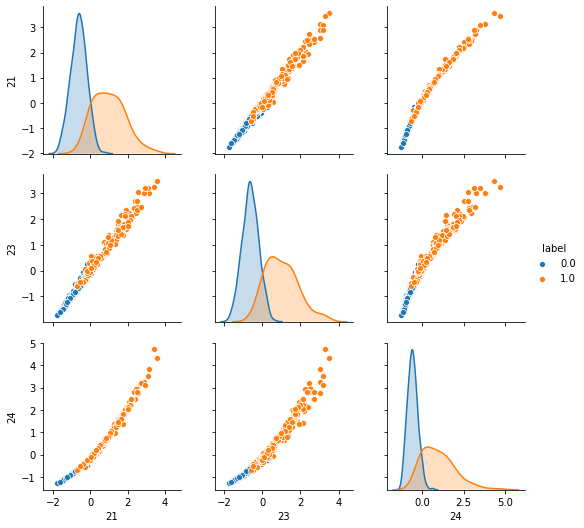

In [14]:
g = sns.pairplot(df_xy, vars=[1,3,4], hue='label')
g = sns.pairplot(df_xy, vars=[11,13,14], hue='label')
g = sns.pairplot(df_xy, vars=[21,23,24], hue='label')

## 3.3.2 Select Features
Features [3,4,13,14,23,24] are not selected, as they share high similarities with other features

(500, 24)
(500, 25)


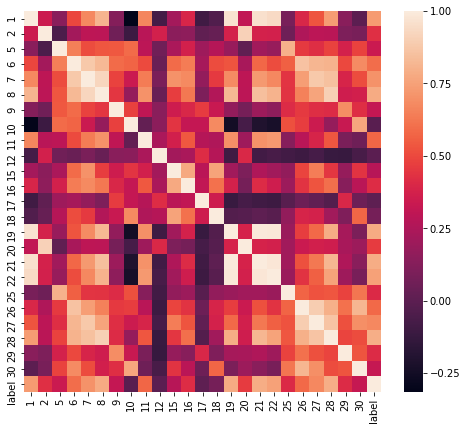

In [15]:

xfs_train = np.concatenate((xs_train[:,0:2], xs_train[:, 4:12], xs_train[:, 16:24], xs_train[:, 24:]), axis=1)
print(xfs_train.shape)
xfs = np.concatenate((xs_train[:,0:2], xs_train[:, 4:12], xs_train[:, 16:24], xs_train[:, 24:], y_train[:, None]), axis=1)
df_fs = pd.DataFrame(xfs,
                  columns=[1, 2, 5, 6, 7, 8, 9, 10, 
                           11, 12, 15, 16, 17, 18, 19, 20,
                           21, 22, 25, 26, 27, 28, 29, 30,'label'])

corr2 = df_fs.corr()
fig,ax=plt.subplots(figsize=(8,7))
sns.heatmap(corr2)
print(xfs.shape)

# 4. Model Training, Cross Validation, Grid Search

## 4.1 Create our Regularized Logistic Regression Model 

In [17]:
model = RegularizedLogisticRegressionUsingGD(eta=1.2,lam=10,n_iterations=1000)
eta = 1.2
lam = 10


## 4.2 Perform K-Fold Cross Validation
5-Fold, with shuffling, and random state = 123

In [18]:
kfold = KFold(5, True, 123)
data = np.concatenate((xfs_train, y_train[:, None]), axis=1)

lr_scores = []

for train, test in kfold.split(data):
    x__train = data[train][:,0:24]
    x__test = data[test][:, 0:24]
    y__train = data[train][:,24:].ravel()
    y__test = data[test][:, 24:].ravel()
    lr_scores.append(get_f1score(model, x__train, x__test, y__train, y__test))
    ##print('train: %s, test: %s' % (data[train].shape, data[test].shape))
    
print("F1 score for each iteration: ", lr_scores)
print("Logistic regression average K-Fold F1 score: ", np.mean(lr_scores))



F1 score for each iteration:  [0.9909909909909909, 0.9848484848484849, 0.9924812030075187, 0.9922480620155039, 0.9838709677419354]
Logistic regression average K-Fold F1 score:  0.9888879417208868


## 4.3 Perform Grid Search on Lambda
From below, lambda = 100 gives the stable coefficient magnitude

F1 score for each iteration:  [0.972972972972973, 0.9848484848484849, 0.9924812030075187, 0.9843749999999999, 0.9836065573770492]
Logistic regression average K-Fold F1 score:  0.9836568436412051 (lambda =  0 )
F1 score for each iteration:  [0.9909909909909909, 0.9848484848484849, 0.9924812030075187, 0.9922480620155039, 0.9838709677419354]
Logistic regression average K-Fold F1 score:  0.9888879417208868 (lambda =  10 )
F1 score for each iteration:  [0.9565217391304348, 0.9701492537313433, 0.9705882352941176, 0.962406015037594, 0.9606299212598425]
Logistic regression average K-Fold F1 score:  0.9640590328906665 (lambda =  100 )
F1 score for each iteration:  [0.9122807017543859, 0.9473684210526316, 0.9172932330827067, 0.9160305343511451, 0.9206349206349206]
Logistic regression average K-Fold F1 score:  0.9227215621751581 (lambda =  500 )


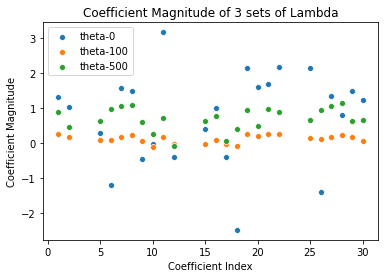

In [19]:
features_label = [ 1,  2,  5,  6,  7,  8,  9, 10, 
                  11, 12, 15, 16, 17, 18, 19, 20,
                  21, 22, 25, 26, 27, 28, 29, 30]

theta = []
lr_f1_score = []

for lam in (0,10,100,500):
    model = RegularizedLogisticRegressionUsingGD(eta=1.2,lam=lam,n_iterations=1000)
    lr_scores = []
    
    i = 0
    for train, test in kfold.split(data):
        x__train = data[train][:,0:24]
        x__test = data[test][:, 0:24]
        y__train = data[train][:,24:].ravel()
        y__test = data[test][:, 24:].ravel()
        lr_scores.append(get_f1score(model, x__train, x__test, y__train, y__test))
        
        ## we pack the x_train and y_train when lambda = 100 and f1 score closest to the mean f1 score
        if (lam == 100 and i == 3):
            f_x_train = x__train
            f_x_test = x__test
            f_y_train = y__train
            f_y_test = y__test
        i+=1
        ##print('train: %s, test: %s' % (data[train].shape, data[test].shape))
        
    theta.append(model.theta())
    # print(model.theta())
    print("F1 score for each iteration: ", lr_scores)
    print("Logistic regression average K-Fold F1 score: ", np.mean(lr_scores), "(lambda = ", lam, ")")
    lr_f1_score.append(np.mean(lr_scores))
    

coeftemp = {'feature_label': features_label, 
            'lambda-0': theta[0], 
            'lambda-10': theta[1], 
            'lambda-100': theta[2],
            'lambda-500': theta[3]}
coef = df_xy = pd.DataFrame(coeftemp)

ax = sns.scatterplot(x="feature_label", y="theta-0", data=coef, label="lambda-0")
ax = sns.scatterplot(x="feature_label", y="theta-100", data=coef, label="lambda-100")
ax = sns.scatterplot(x="feature_label", y="theta-500", data=coef, label="lambda-500")

plt.title('Coefficient Magnitude of 3 sets of Lambda')
plt.xlabel('Coefficient Index')
plt.ylabel('Coefficient Magnitude')
plt.legend()


## 4.4 Perform Grid Search CV on Lambda and Learning Rate

In [20]:
eta_label = []
lam_label = []
lr_f1 = []

max_f1 = 0
cur_eta = 0
cur_lam = 0

for eta in (1.5, 1, 0.5 , 0 , 0.1,0.01,0.001):
    for lam in (0,10,100,200,300,400,500):
        model = RegularizedLogisticRegressionUsingGD(eta=eta,lam=lam,n_iterations=1000)
        lr_scores = []

        i = 0
        for train, test in kfold.split(data):
            x__train = data[train][:,0:24]
            x__test = data[test][:, 0:24]
            y__train = data[train][:,24:].ravel()
            y__test = data[test][:, 24:].ravel()
            
            temp_f1 = get_f1score(model, x__train, x__test, y__train, y__test)
            if (temp_f1 > max_f1):
                max_f1 = temp_f1
                cur_eta = eta
                cur_lam = lam
                ##print("current eta: %f, lam: %d, k: %d" %  (eta, lam, i))
                ##print(max_f1)
            lr_scores.append(temp_f1)

            ## we pack the x_train and y_train when lambda = 100 and f1 score closest to the mean f1 score
            if (lam == 100 and i == 3):
                f_x_train = x__train
                f_x_test = x__test
                f_y_train = y__train
                f_y_test = y__test
            i+=1
            ##print('train: %s, test: %s' % (data[train].shape, data[test].shape))

        # theta.append(model.theta())
        # print(model.theta())
        # print("F1 score for each iteration: ", lr_scores)
        # print("Logistic regression average K-Fold F1 score: ", np.mean(lr_scores), "(lambda = ", lam, ")")
        # lr_f1_score.append(np.mean(lr_scores))
        
        lam_label.append(lam)
        eta_label.append(eta)
        lr_f1.append(np.mean(lr_scores))
        
lr_best_f1 = max_f1
lr_best_para = {'eta': cur_eta, 'lam': cur_lam}



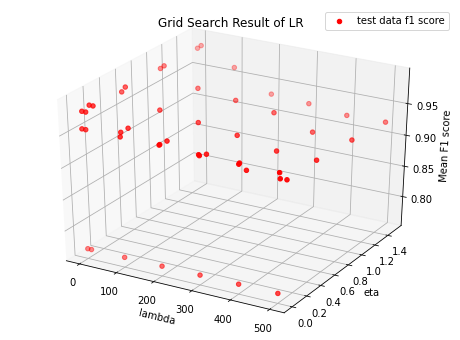

In [21]:
X_axis = lam_label
Y_axis = eta_label

test_axis = lr_f1

plt.figure(figsize=(8,6))
ax = plt.axes(projection='3d')
ax.scatter(X_axis, Y_axis, test_axis, c='red', label='test data f1 score')


plt.title('Grid Search Result of LR')
ax.set_xlabel('lambda')
ax.set_ylabel('eta')
ax.set_zlabel('Mean F1 score')
ax.legend();

In [22]:
# xtrain, xtest, ytrain, ytest = train_test_split(xfs_train, y_train, test_size=0.2, random_state=34)
model = RegularizedLogisticRegressionUsingGD(eta=1.2,lam=100, n_iterations=1000)

model.fit(f_x_train, f_y_train)

pred = model.predict(f_x_test)

print("LR accuracy: ", accuracy(f_y_test, pred))
report = classification_report(f_y_test,pred)
print(report)

LR accuracy:  0.95
              precision    recall  f1-score   support

         0.0       0.94      0.98      0.96        65
         1.0       0.97      0.89      0.93        35

    accuracy                           0.95       100
   macro avg       0.95      0.94      0.94       100
weighted avg       0.95      0.95      0.95       100



# 5. Predict the testing data
## 5.1 Testing data pre-processing (import data, feature scaling, feature selection)

In [23]:
testing_data = np.loadtxt('X_test.csv', dtype=float, delimiter=',')
scale = StandardScaler()
scaled_test = scale.fit_transform(testing_data)
print("before feature selection: ", scaled_test.shape)

final_test = np.concatenate((scaled_test[:,0:2], scaled_test[:, 4:12], scaled_test[:, 16:24], scaled_test[:, 24:]), axis=1)
print("after feature selection: ", final_test.shape)



before feature selection:  (50, 30)
after feature selection:  (50, 24)


## 5.2 Predict the testing data and save it in a CSV

In [24]:
real_pred = model.predict(final_test)

print(real_pred)

Y_pred = np.asarray(real_pred)
np.savetxt("wongmanfai_17041832d.csv", Y_pred, delimiter=",")

[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1]


# 6. Use Neural Network to Predict the data 
## 6.1 Multi-layer Perceptron classifier

In [25]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV


print("Pre-processed data")
print(xfs_train.shape)
print(y_train.shape)

Pre-processed data
(500, 24)
(500,)


In [26]:
mlp = MLPClassifier(hidden_layer_sizes=(10,10,10), activation='relu', alpha=0.1 ,solver='adam', max_iter=500)

nn_xtrain, nn_xtest, nn_ytrain, nn_ytest = train_test_split(xfs_train, y_train, test_size=0.2, random_state=34)

mlp.fit(nn_xtrain, nn_ytrain)

predict_train = mlp.predict(nn_xtrain)
predict_test = mlp.predict(nn_xtest)

print(confusion_matrix(nn_ytest,predict_test))
print(classification_report(nn_ytest,predict_test))

[[61  0]
 [ 4 35]]
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        61
           1       1.00      0.90      0.95        39

    accuracy                           0.96       100
   macro avg       0.97      0.95      0.96       100
weighted avg       0.96      0.96      0.96       100



## 6.2 Grid Search Cross Validation
on max_iter, alpha, hidden_layer_sizes, random_state

In [27]:
parameters = {'solver': ['lbfgs'], 
              'max_iter': [100, 500, 1000,2000, 3000], 
              'alpha': [10**-1,10**-2,10**-3,10**-4,10**-5,10**-6,10**-7,10**-8,10**-9], 
              'hidden_layer_sizes':[(10,10,10), (10,20,30), (100,100,100)], 
              'random_state':[0,1,2]}
mlp_gscv = GridSearchCV(MLPClassifier(), parameters,scoring='f1', n_jobs=-1)
mlp_gscv

GridSearchCV(cv=None, error_score=nan,
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_fun=15000,
                                     max_iter=200, momentum=0.9,
                                     n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_st...
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': [0.1, 0.01, 0.001, 0.0001, 1e-05, 1e-06,
                                

In [28]:
mlp_gscv.fit(xfs_train, y_train)
print(mlp_gscv.score(xfs_train, y_train))
print(mlp_gscv.best_params_)

0.9946524064171123
{'alpha': 0.01, 'hidden_layer_sizes': (10, 10, 10), 'max_iter': 100, 'random_state': 0, 'solver': 'lbfgs'}


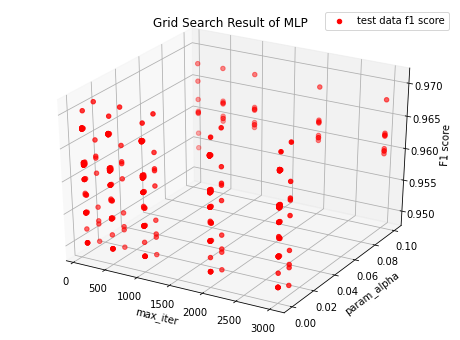

In [29]:
X_axis = mlp_gscv.cv_results_['param_max_iter'].data
Y_axis = mlp_gscv.cv_results_['param_alpha'].data

test_axis = abs(mlp_gscv.cv_results_['mean_test_score'])

plt.figure(figsize=(8,6))
ax = plt.axes(projection='3d')
ax.scatter(X_axis, Y_axis, test_axis, c='red', label='test data f1 score')

plt.title('Grid Search Result of MLP')
ax.set_xlabel('max_iter')
ax.set_ylabel('param_alpha')
ax.set_zlabel('F1 score')
ax.legend();

In [30]:
print("Logistic regression best F1 score: ", lr_best_f1)
print("Logistic regression best parameter set: ", lr_best_para)

Logistic regression best F1 score:  0.9924812030075187
Logistic regression best parameter set:  {'eta': 1.5, 'lam': 0}


In [31]:
mlp_pred = mlp_gscv.predict(final_test)
print(mlp_pred)

mlp_Y_pred = np.asarray(mlp_pred)
np.savetxt("prediction_result.csv", mlp_Y_pred, delimiter=",")

[0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 1 1 0 1 0 0 1 0 0 1 0 0 0 1
 0 0 1 1 0 1 0 0 0 0 0 1 1]
